# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression, LassoLars, Lars
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor
from sklearn.svm import SVR
# Bayesian Optimizer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,Core CPI - Services - Dining Out,Terms of Trade - Exports,Terms of Trade - Imports,Chicken Placements (thousands),Private Credit - ME - Consumption (mill US$),Private Credit - MN - Consumption (mill S/),Private Credit - MN - Mortgage (mill S/),Capacity Utilization - Food & Beverages,Electricity Production - Lima (GWh),...,"Dependent Worker (3-month MA, thousands)","Unpaid Worker (3-month MA, thousands)","Firms 1-10 Workers (3-month MA, thousands)","Firms 11-50 Workers (3-month MA, thousands)","Firms 51+ Workers (3-month MA, thousands)","Adequately Employed (3-month MA, thousands)","Underemployed (3-month MA, thousands)",Employment Ratio (3-month MA),Monthly Income (3-month MA),"Unemployment Rate (3-month MA, %)"
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,0.493711,1.222114,0.637752,0.019147,0.003929,0.008218,0.005268,0.073791,0.053100,...,0.003075,-0.009630,0.003672,0.025094,-0.016357,0.010773,-0.014092,-0.002963,0.007206,0.059598
2023-09-01,0.133933,0.466855,2.545351,0.498539,-0.032237,0.006853,0.002300,0.009073,0.093072,0.000330,...,-0.012249,-0.236708,0.000451,-0.022502,-0.003658,-0.002652,-0.004252,-0.006672,-0.003658,0.014112
2023-10-01,0.085365,0.439759,-1.221888,0.418250,0.016049,0.016984,0.003725,0.006669,-0.043358,-0.031960,...,-0.004473,-0.023207,0.014899,-0.061290,0.005309,0.009151,-0.004133,0.000334,0.005766,-0.026198
2023-11-01,0.036736,0.412382,0.766457,-0.877823,0.008049,0.005182,0.000605,0.006279,0.015830,-0.102170,...,0.004042,-0.036390,0.024137,-0.017521,-0.003176,-0.012732,0.048607,0.008813,-0.019686,0.001051
2023-12-01,-0.011845,0.384683,1.103257,-2.321367,-0.027293,-0.025853,-0.002890,0.003147,-0.080944,-0.195104,...,0.002075,0.255287,0.005681,0.010032,0.002840,0.014463,-0.007180,0.002026,0.006210,-0.027032


In [4]:
df_lags = pd.read_csv('../../../input/df_lags.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,Core CPI - Services - Dining Out_lag_1,Core CPI - Services - Dining Out_lag_2,Core CPI - Services - Dining Out_lag_3,Terms of Trade - Exports_lag_1,Terms of Trade - Exports_lag_2,Terms of Trade - Exports_lag_3,Terms of Trade - Imports_lag_1,Terms of Trade - Imports_lag_2,Terms of Trade - Imports_lag_3,...,"Underemployed (3-month MA, thousands)_lag_3",Employment Ratio (3-month MA)_lag_1,Employment Ratio (3-month MA)_lag_2,Employment Ratio (3-month MA)_lag_3,Monthly Income (3-month MA)_lag_1,Monthly Income (3-month MA)_lag_2,Monthly Income (3-month MA)_lag_3,"Unemployment Rate (3-month MA, %)_lag_1","Unemployment Rate (3-month MA, %)_lag_2","Unemployment Rate (3-month MA, %)_lag_3"
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,0.520360,0.546821,0.573096,0.108717,1.411009,-3.488401,0.205259,-0.477097,-1.960619,...,0.007109,-0.001862,0.006970,-0.008402,0.006234,0.010346,0.017119,-0.043834,-0.033525,-0.041515
2023-09-01,0.133933,0.493711,0.520360,0.546821,1.222114,0.108717,1.411009,0.637752,0.205259,-0.477097,...,-0.000207,-0.002963,-0.001862,0.006970,0.007206,0.006234,0.010346,0.059598,-0.043834,-0.033525
2023-10-01,0.085365,0.466855,0.493711,0.520360,2.545351,1.222114,0.108717,0.498539,0.637752,0.205259,...,-0.018183,-0.006672,-0.002963,-0.001862,-0.003658,0.007206,0.006234,0.014112,0.059598,-0.043834
2023-11-01,0.036736,0.439759,0.466855,0.493711,-1.221888,2.545351,1.222114,0.418250,0.498539,0.637752,...,-0.014092,0.000334,-0.006672,-0.002963,0.005766,-0.003658,0.007206,-0.026198,0.014112,0.059598
2023-12-01,-0.011845,0.412382,0.439759,0.466855,0.766457,-1.221888,2.545351,-0.877823,0.418250,0.498539,...,-0.004252,0.008813,0.000334,-0.006672,-0.019686,0.005766,-0.003658,0.001051,-0.026198,0.014112


In [5]:
df = df[:'2019-12-01']
df_lags = df_lags[:'2019-12-01'] 

## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [6]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2019-01-01,1,0.19049
2019-02-01,2,0.19049
2019-03-01,3,0.19049
2019-04-01,4,0.19049
2019-05-01,5,0.19049
2019-06-01,6,0.19049
2019-07-01,7,0.19049
2019-08-01,8,0.19049
2019-09-01,9,0.19049


In [7]:
# We create our results dataframe, concatenating the predicted and the actual values
results_rw = pd.concat([predicted, test_set[target]], axis=1)
results_rw.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results_rw

,Horizon,Predicted,Actual
Fecha,,,
2019-01-01,1,0.19049,0.183963
2019-02-01,2,0.19049,0.175141
2019-03-01,3,0.19049,0.166761
2019-04-01,4,0.19049,0.160654
2019-05-01,5,0.19049,0.157488
2019-06-01,6,0.19049,0.156027
2019-07-01,7,0.19049,0.155721
2019-08-01,8,0.19049,0.156584
2019-09-01,9,0.19049,0.156844


In [8]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results_rw, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.006527,0.035478
2,0.011793,0.061556
3,0.016746,0.088469
4,0.020805,0.112780
5,0.023751,0.132134
6,0.025846,0.146924
7,0.027300,0.157831
8,0.028210,0.165169
9,0.028865,0.170652
10,0.029558,0.176242


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [9]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

In [10]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.183810,0.183963
2019-02-01,0.174572,0.175141
2019-03-01,0.163781,0.166761
2019-04-01,0.152346,0.160654
2019-05-01,0.141179,0.157488
2019-06-01,0.131144,0.156027
2019-07-01,0.122793,0.155721
2019-08-01,0.116382,0.156584
2019-09-01,0.111980,0.156844


In [11]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.000153,0.000833
2,0.000417,0.002043
3,0.001754,0.007318
4,0.004423,0.018416
5,0.008297,0.035445
6,0.012672,0.056118
7,0.017103,0.078309
8,0.021401,0.100613
9,0.025115,0.121217
10,0.027880,0.138575


<Axes: >

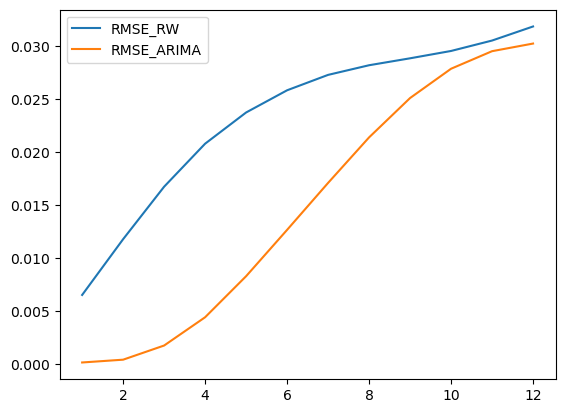

In [12]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima], axis=1)

rmse_econometrics.plot()

### 3.1.3 Vector autoregression (VAR)

In [13]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2019-01-01']
test_set  = df[df.index >= '2019-01-01']

In [14]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(3)

In [15]:
# Summary of the model
# model_fit.summary()

In [16]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-3:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results_var = pd.concat([preds, test_set[target]],axis=1)
results_var.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_var

,Predicted,Actual
Fecha,,
2019-01-01,0.128511,0.183963
2019-02-01,0.114930,0.175141
2019-03-01,0.124422,0.166761
2019-04-01,0.121974,0.160654
2019-05-01,0.122877,0.157488
2019-06-01,0.137699,0.156027
2019-07-01,0.147662,0.155721
2019-08-01,0.159871,0.156584
2019-09-01,0.176011,0.156844


In [17]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results_var, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.055452,0.301432
2,0.057881,0.322609
3,0.053207,0.299703
4,0.049973,0.284968
5,0.047301,0.271929
6,0.043823,0.246185
7,0.040687,0.218409
8,0.038077,0.193732
9,0.036463,0.185785
10,0.036081,0.188097


<Axes: >

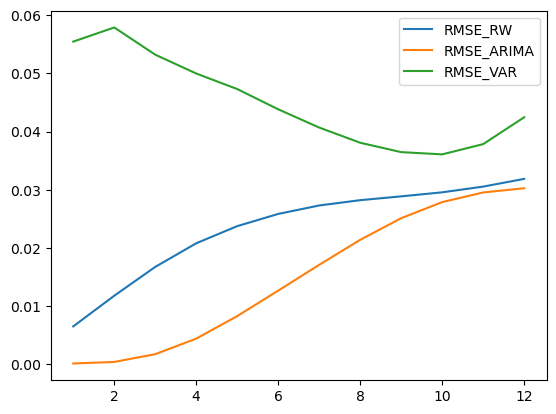

In [18]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [19]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(l1_ratio=0, random_state=2024))  
])

# Define grid search
grid_params_ridge = {
    'regressor__alpha': np.linspace(0.01, 10, 1000) 
}


# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_ridge, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=500, random_state=2024)
grid_search.fit( X_train, y_train )
grid_search_ridge = pd.DataFrame( grid_search.cv_results_ )

ridge_model  = grid_search.best_estimator_
ridge_params = grid_search.best_params_

In [20]:
pred_vars = X_train.columns.to_list()
coefficients = ridge_model.named_steps['regressor'].coef_
vars_df_ridge      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_ridge_h19.xlsx' )

In [21]:
y_pred = ridge_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
results_ridge = pd.concat([y_pred, y_test],axis=1)
results_ridge.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_ridge

,Predicted,Actual
Fecha,,
2019-01-01,0.197707,0.183963
2019-02-01,0.203747,0.175141
2019-03-01,0.206132,0.166761
2019-04-01,0.197299,0.160654
2019-05-01,0.197817,0.157488
2019-06-01,0.185831,0.156027
2019-07-01,0.166383,0.155721
2019-08-01,0.173401,0.156584
2019-09-01,0.166629,0.156844


In [22]:
RMSE_ridge, MAPE_ridge = get_metrics(results_ridge, 'Ridge')

<Axes: >

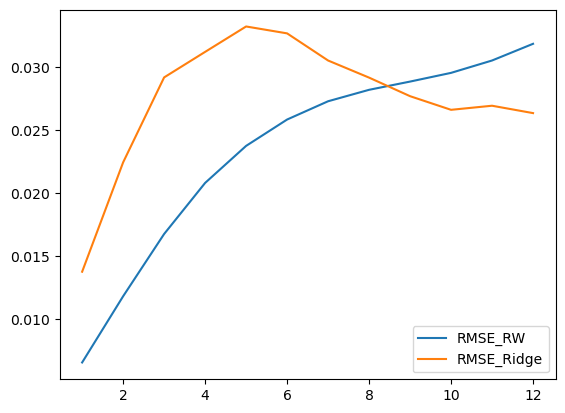

In [23]:
pd.concat([RMSE_rw, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [24]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(l1_ratio=1, random_state=2024))  
])

# Define grid search
grid_params_lasso = {
    'regressor__alpha': np.linspace(0.01, 10, 1000) 
}


# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_lasso, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=250, random_state=2024)
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

lasso_model  = grid_search.best_estimator_
lasso_params = grid_search.best_params_

In [25]:
pred_vars = X_train.columns.to_list()
coefficients = lasso_model.named_steps['regressor'].coef_
vars_df_lasso      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_lasso_h19.xlsx' )

In [26]:
y_pred = lasso_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [27]:
results_lasso = pd.concat([y_pred, y_test],axis=1)
results_lasso.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_lasso

,Predicted,Actual
Fecha,,
2019-01-01,0.181611,0.183963
2019-02-01,0.184006,0.175141
2019-03-01,0.184588,0.166761
2019-04-01,0.177281,0.160654
2019-05-01,0.172524,0.157488
2019-06-01,0.169890,0.156027
2019-07-01,0.167948,0.155721
2019-08-01,0.167445,0.156584
2019-09-01,0.167917,0.156844


<Axes: >

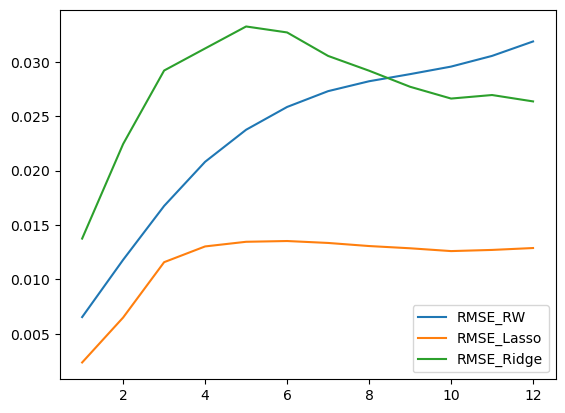

In [28]:
RMSE_lasso, MAPE_lasso = get_metrics(results_lasso, 'Lasso')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge], axis=1).plot()

### 3.2.3 Elastic Net (EN)

In [29]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(l1_ratio=0.5, random_state=2024))  
])

# Define grid search
grid_params_en = {
    'regressor__alpha': np.linspace(0.01, 10, 1000),
}


# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_en, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=250, random_state=2024)
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

en_model  = grid_search.best_estimator_
en_params = grid_search.best_params_

In [30]:
pred_vars = X_train.columns.to_list()
coefficients = en_model.named_steps['regressor'].coef_
vars_df_en      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_en      = vars_df_en.reindex( vars_df_en[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_en.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_en_h19.xlsx' )

In [31]:
y_pred = en_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [32]:
results_en = pd.concat([y_pred, y_test],axis=1)
results_en.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_en

,Predicted,Actual
Fecha,,
2019-01-01,0.175778,0.183963
2019-02-01,0.179707,0.175141
2019-03-01,0.183266,0.166761
2019-04-01,0.170464,0.160654
2019-05-01,0.162779,0.157488
2019-06-01,0.159670,0.156027
2019-07-01,0.156442,0.155721
2019-08-01,0.156117,0.156584
2019-09-01,0.158211,0.156844


<Axes: >

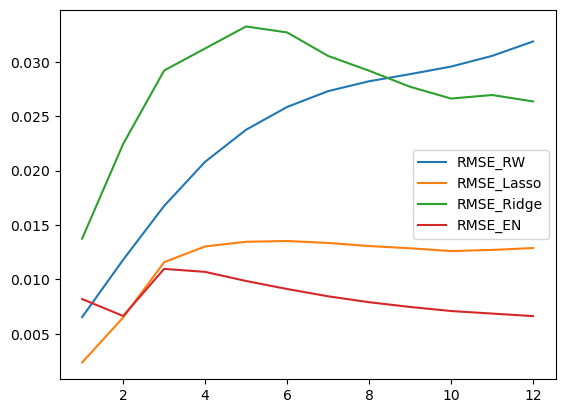

In [33]:
RMSE_en, MAPE_en = get_metrics(results_en, 'EN')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_en], axis=1).plot()

### 3.2.4 Least Angle Regression (LARS)

In [34]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', Lars(random_state=2024))  
])

# Define grid search
grid_params_lars = {
    'regressor__n_nonzero_coefs': np.arange(1, X.shape[1] + 1)  # Probando diferentes números de coeficientes no nulos
}

# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_lars, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=250, random_state=2024)
grid_search.fit( X_train, y_train )
grid_search_lars = pd.DataFrame( grid_search.cv_results_ )

lars_model  = grid_search.best_estimator_
lars_params = grid_search.best_params_

In [35]:
pred_vars = X_train.columns.to_list()
coefficients = lars_model.named_steps['regressor'].coef_
vars_df_lars      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_lars      = vars_df_lars.reindex( vars_df_lars[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lars.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_lars_h19.xlsx' )

In [36]:
y_pred = lars_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
results_lars = pd.concat([y_pred, y_test],axis=1)
results_lars.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_lars

,Predicted,Actual
Fecha,,
2019-01-01,0.189306,0.183963
2019-02-01,0.190010,0.175141
2019-03-01,0.187055,0.166761
2019-04-01,0.186049,0.160654
2019-05-01,0.184618,0.157488
2019-06-01,0.182488,0.156027
2019-07-01,0.182091,0.155721
2019-08-01,0.181408,0.156584
2019-09-01,0.180037,0.156844


<Axes: >

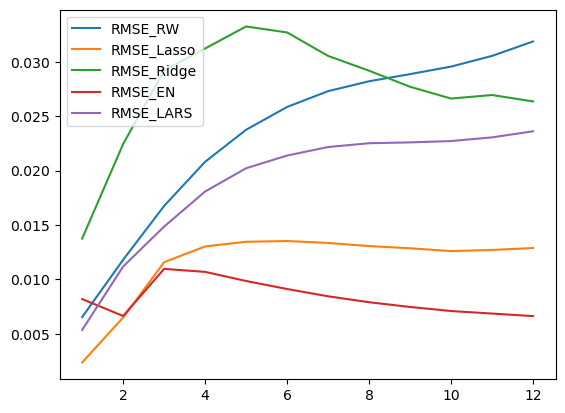

In [37]:
RMSE_lars, MAPE_lars = get_metrics(results_lars, 'LARS')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars], axis=1).plot()

### 3.2.5 Random Forest Regression (Random Forest)

In [38]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', RandomForestRegressor(random_state=2024))  
])


# Define grid search
grid_params_rf = {
    'regressor__n_estimators': np.arange(90, 501, 5),  # Genera enteros desde 90 hasta 500 inclusive, con paso de 5
    'regressor__max_depth': np.arange(5, 51),  # Genera enteros desde 5 hasta 50 inclusive
    'regressor__min_samples_split': [2, 5, 10],  # Valores válidos para min_samples_split
    'regressor__min_samples_leaf': [1, 2, 4],    # Valores válidos para min_samples_leaf
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_rf, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=250, random_state=2024)
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

rf_model  = grid_search.best_estimator_
rf_params = grid_search.best_params_

In [39]:
pred_vars = X_train.columns.to_list()
feature_importances = rf_model.named_steps['regressor'].feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_rf_h19_1.xlsx' )

In [40]:
y_pred = rf_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
results_rf = pd.concat([y_pred, y_test],axis=1)
results_rf.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_rf

,Predicted,Actual
Fecha,,
2019-01-01,0.191947,0.183963
2019-02-01,0.201431,0.175141
2019-03-01,0.201360,0.166761
2019-04-01,0.188863,0.160654
2019-05-01,0.186833,0.157488
2019-06-01,0.185844,0.156027
2019-07-01,0.180231,0.155721
2019-08-01,0.181183,0.156584
2019-09-01,0.186263,0.156844


<Axes: >

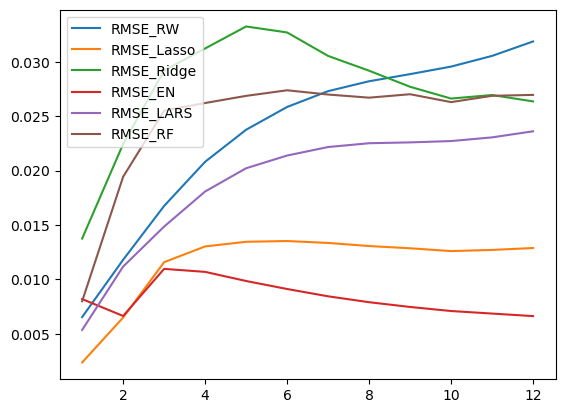

In [41]:
RMSE_rf, MAPE_rf = get_metrics(results_rf, 'RF')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars, RMSE_rf], axis=1).plot()

### 3.2.5 Support Vector Machine (SVM)

In [42]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
scaler = StandardScaler()
svm = SVR()
model = Pipeline([
    ('scaler', scaler),
    ('svm', svm)
])

# Define grid search
param_grid_svm = {
    'svm__C': np.linspace(0.1, 100, 100),
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'linear']
}

# We implement the gridsearch
grid_search = RandomizedSearchCV( model, param_grid_svm, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=250, random_state=2024)
grid_search.fit( X_train, y_train )
grid_search_svm = pd.DataFrame( grid_search.cv_results_ )

svm_model  = grid_search.best_estimator_
svm_params = grid_search.best_params_

In [43]:
y_pred = svm_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
results_svm = pd.concat([y_pred, y_test],axis=1)
results_svm.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_svm

,Predicted,Actual
Fecha,,
2019-01-01,0.207391,0.183963
2019-02-01,0.200388,0.175141
2019-03-01,0.200607,0.166761
2019-04-01,0.205359,0.160654
2019-05-01,0.213895,0.157488
2019-06-01,0.219664,0.156027
2019-07-01,0.215474,0.155721
2019-08-01,0.207194,0.156584
2019-09-01,0.199973,0.156844


<Axes: >

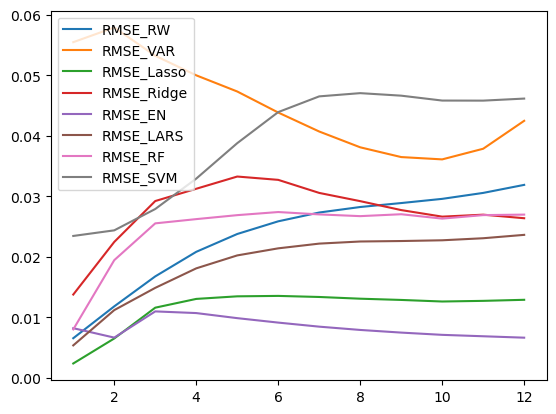

In [44]:
RMSE_svm, MAPE_svm = get_metrics(results_svm, 'SVM')
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars, RMSE_rf, RMSE_svm], axis=1).plot()

### 3.2.5 Random Forest Regression (Random Forest) using RandomizedCV

In [45]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', RandomForestRegressor(random_state=2024))  
])

# Define grid search
grid_params_rf = {
    'regressor__n_estimators': np.arange(50, 150, 5),  
    'regressor__max_depth': np.arange(5, 51),
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}


# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_rf, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=250, random_state=2024)
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

rf_model_2  = grid_search.best_estimator_
rf_params_2 = grid_search.best_params_

In [46]:
pred_vars = X_train.columns.to_list()
feature_importances = rf_model_2.named_steps['regressor'].feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_rf_h19_2.xlsx' )

In [47]:
y_pred = rf_model_2.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [48]:
results_rf_2 = pd.concat([y_pred, y_test],axis=1)
results_rf_2.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_rf_2

,Predicted,Actual
Fecha,,
2019-01-01,0.170908,0.183963
2019-02-01,0.205190,0.175141
2019-03-01,0.196620,0.166761
2019-04-01,0.194737,0.160654
2019-05-01,0.174370,0.157488
2019-06-01,0.200798,0.156027
2019-07-01,0.164710,0.155721
2019-08-01,0.183937,0.156584
2019-09-01,0.171273,0.156844


In [49]:
RMSE_rf_2, MAPE_rf_2 = get_metrics(results_rf_2, 'RF_2')

<Axes: >

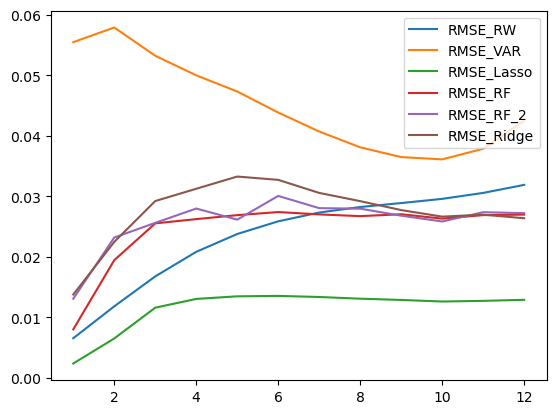

In [50]:
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_rf, RMSE_rf_2, RMSE_ridge], axis=1).plot()

### 3.2.4 Random Forest Regression (Random Forest) using BayesSearchCV

In [51]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(random_state=2024)
model = random_forest

param_space = {
    'n_estimators': Integer(50, 150),
    'max_features': Real(0.1, 0.9, prior='uniform'),
    'max_depth': Integer(10, 50),
    'min_samples_split': Integer(2, 16),
    'min_samples_leaf': Integer(1, 6)
}

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=250,  
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=2024)

opt.fit( X_train, y_train )

#pd.DataFrame( grid_search.cv_results_ )

# And select out best model
rf_model_bayes  = opt.best_estimator_
rf_params_bayes = opt.best_params_
rf_score_bayes = opt.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [52]:
pred_vars = X_train.columns.to_list()
feature_importances = rf_model_bayes.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/analysis_07/h19/coef_rf_bayes.xlsx' )

In [53]:
y_pred = rf_model_bayes.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [54]:
results_rf_bayes = pd.concat([y_pred, y_test],axis=1)
results_rf_bayes.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_rf_bayes

,Predicted,Actual
Fecha,,
2019-01-01,0.163130,0.183963
2019-02-01,0.173633,0.175141
2019-03-01,0.181953,0.166761
2019-04-01,0.178045,0.160654
2019-05-01,0.173409,0.157488
2019-06-01,0.176600,0.156027
2019-07-01,0.159975,0.155721
2019-08-01,0.154403,0.156584
2019-09-01,0.164835,0.156844


In [55]:
RMSE_rf_bayes, MAPE_rf_bayes = get_metrics(results_rf_bayes, 'RF_Bayes')

<Axes: >

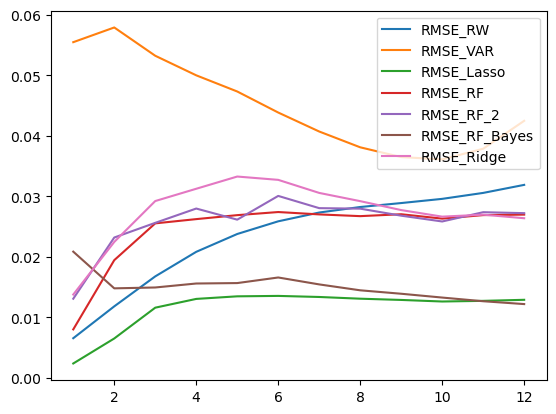

In [56]:
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_rf, RMSE_rf_2, RMSE_rf_bayes, RMSE_ridge], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest) using BayesSearchCV and categorical

In [57]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(random_state=2024)
model = random_forest

param_space = {
    'n_estimators': Integer(100, 500),
    'max_features': Categorical([0.1, 0.2, 0.3, 0.4, 0.5, 'log2', 'sqrt']),
    'max_depth': Integer(10, 50),
    'min_samples_split': Integer(2, 16),
    'min_samples_leaf': Integer(1, 6)
}

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=250,  
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=2024)

opt.fit( X_train, y_train )

#pd.DataFrame( grid_search.cv_results_ )

# And select out best model
rf_model_bayes_2  = opt.best_estimator_
rf_params_bayes_2 = opt.best_params_
rf_score_bayes_2 = opt.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [58]:
y_pred = rf_model_bayes_2.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [59]:
results_rf_bayes_2 = pd.concat([y_pred, y_test],axis=1)
results_rf_bayes_2.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_rf_bayes_2

,Predicted,Actual
Fecha,,
2019-01-01,0.197340,0.183963
2019-02-01,0.195824,0.175141
2019-03-01,0.196730,0.166761
2019-04-01,0.195479,0.160654
2019-05-01,0.179352,0.157488
2019-06-01,0.189490,0.156027
2019-07-01,0.182115,0.155721
2019-08-01,0.185063,0.156584
2019-09-01,0.179593,0.156844


In [60]:
RMSE_rf_bayes_2, MAPE_rf_bayes_2 = get_metrics(results_rf_bayes_2, 'RF_Bayes_2')

<Axes: >

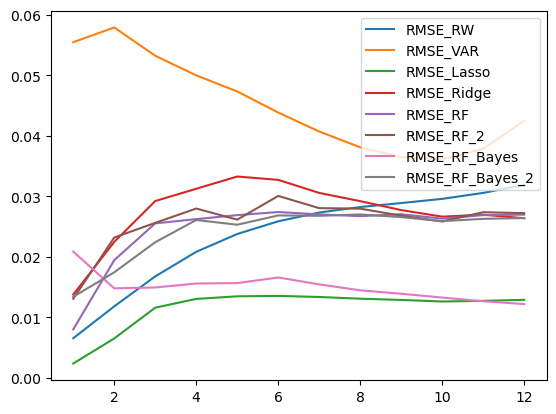

In [61]:
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_ridge, RMSE_rf, RMSE_rf_2, RMSE_rf_bayes, RMSE_rf_bayes_2], axis=1).plot()

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [62]:
RMSE_2019 = pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars, RMSE_rf, RMSE_rf_2, RMSE_rf_bayes, RMSE_rf_bayes_2, RMSE_svm], axis=1)
MAPE_2019 = pd.concat([MAPE_rw, MAPE_var, MAPE_lasso, MAPE_ridge, MAPE_en, MAPE_lars, MAPE_rf, MAPE_rf_2, MAPE_rf_bayes, MAPE_rf_bayes_2, MAPE_svm], axis=1)

In [63]:
RMSE_2019

,RMSE_RW,RMSE_VAR,RMSE_Lasso,RMSE_Ridge,RMSE_EN,RMSE_LARS,RMSE_RF,RMSE_RF_2,RMSE_RF_Bayes,RMSE_RF_Bayes_2,RMSE_SVM
1,0.006527,0.055452,0.002352,0.013744,0.008185,0.005343,0.007984,0.013055,0.020833,0.013377,0.023428
2,0.011793,0.057881,0.006486,0.022441,0.006627,0.011172,0.019428,0.023167,0.014770,0.017417,0.024354
3,0.016746,0.053207,0.011575,0.029197,0.010959,0.014849,0.025508,0.025593,0.014912,0.022397,0.027880
4,0.020805,0.049973,0.013023,0.031226,0.010683,0.018072,0.026210,0.027958,0.015569,0.026066,0.032903
5,0.023751,0.047301,0.013450,0.033246,0.009844,0.020211,0.026866,0.026121,0.015640,0.025281,0.038761
6,0.025846,0.043823,0.013520,0.032698,0.009108,0.021380,0.027380,0.030044,0.016564,0.026819,0.043897
7,0.027300,0.040687,0.013343,0.030539,0.008437,0.022162,0.026989,0.028022,0.015420,0.026758,0.046494
8,0.028210,0.038077,0.013058,0.029179,0.007894,0.022512,0.026701,0.027940,0.014444,0.026980,0.047029
9,0.028865,0.036463,0.012853,0.027703,0.007456,0.022589,0.027017,0.026777,0.013876,0.026543,0.046611
10,0.029558,0.036081,0.012594,0.026619,0.007084,0.022711,0.026291,0.025820,0.013246,0.025874,0.045803


Text(0.5, 1.0, 'RMSE of different models for 2019')

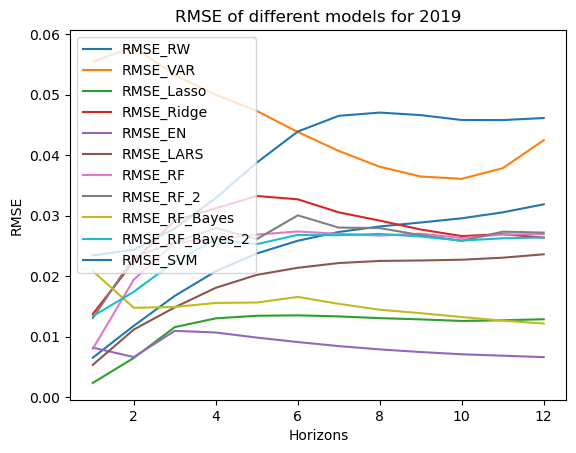

In [64]:
RMSE_2019.plot()

plt.xlabel('Horizons')
plt.ylabel('RMSE')
plt.title('RMSE of different models for 2019')


In [65]:
RMSE_2019_results = RMSE_2019.div(RMSE_rw['RMSE_RW'], axis=0)
# RMSE_2019_results = RMSE_2019_results.drop(columns=['RMSE_RW'])
RMSE_2019_results_highlight = RMSE_2019_results.style.apply(highlight_min, axis=1)
RMSE_2019_results_highlight

,RMSE_RW,RMSE_VAR,RMSE_Lasso,RMSE_Ridge,RMSE_EN,RMSE_LARS,RMSE_RF,RMSE_RF_2,RMSE_RF_Bayes,RMSE_RF_Bayes_2,RMSE_SVM
1,1.000000,8.496228,0.360432,2.105803,1.254040,0.818689,1.223294,2.000181,3.191927,2.049615,3.589569
2,1.000000,4.907858,0.549925,1.902827,0.561922,0.947334,1.647350,1.964352,1.252349,1.476849,2.065062
3,1.000000,3.177385,0.691222,1.743549,0.654422,0.886766,1.523298,1.528334,0.890490,1.337493,1.664897
4,1.000000,2.401939,0.625953,1.500876,0.513488,0.868644,1.259766,1.343809,0.748313,1.252844,1.581481
5,1.000000,1.991561,0.566284,1.399801,0.414467,0.850969,1.131160,1.099806,0.658492,1.064436,1.631991
6,1.000000,1.695543,0.523075,1.265092,0.352411,0.827204,1.059335,1.162430,0.640875,1.037624,1.698395
7,1.000000,1.490358,0.488738,1.118660,0.309056,0.811791,0.988591,1.026464,0.564818,0.980163,1.703093
8,1.000000,1.349741,0.462883,1.034340,0.279827,0.797998,0.946512,0.990402,0.512018,0.956368,1.667066
9,1.000000,1.263237,0.445270,0.959750,0.258324,0.782562,0.935980,0.927676,0.480728,0.919553,1.614814
10,1.000000,1.220706,0.426084,0.900570,0.239658,0.768365,0.889493,0.873535,0.448144,0.875375,1.549599


In [66]:
MAPE_2019_results = MAPE_2019.div(MAPE_rw['MAPE_RW'], axis=0)
# MAPE_2019_results = MAPE_2019_results.drop(columns=['MAPE_RW'])
MAPE_2019_results_highlight = MAPE_2019_results.style.apply(highlight_min, axis=1)
MAPE_2019_results_highlight

,MAPE_RW,MAPE_VAR,MAPE_Lasso,MAPE_Ridge,MAPE_EN,MAPE_LARS,MAPE_RF,MAPE_RF_2,MAPE_RF_Bayes,MAPE_RF_Bayes_2,MAPE_SVM
1,1.000000,8.496228,0.360432,2.105803,1.254040,0.818689,1.223294,2.000181,3.191927,2.049615,3.589569
2,1.000000,5.240868,0.515010,1.933515,0.573126,0.925523,1.571777,1.970015,0.989792,1.549857,2.205304
3,1.000000,3.387669,0.641684,1.786460,0.638786,0.887854,1.510843,1.588470,0.802381,1.396055,1.787683
4,1.000000,2.526755,0.606942,1.556656,0.511180,0.872749,1.278092,1.404816,0.712030,1.301850,1.668588
5,1.000000,2.057981,0.558944,1.450519,0.399898,0.856681,1.154746,1.121490,0.639203,1.099071,1.681476
6,1.000000,1.675596,0.519689,1.303772,0.326187,0.834417,1.082196,1.165993,0.628618,1.066979,1.722836
7,1.000000,1.383816,0.485733,1.102265,0.264457,0.819065,1.005957,0.982601,0.526303,1.004767,1.721975
8,1.000000,1.172934,0.458626,1.002911,0.223377,0.804821,0.959999,0.953783,0.450597,0.977759,1.684400
9,1.000000,1.088677,0.440535,0.903455,0.197849,0.788691,0.948041,0.880467,0.420832,0.935631,1.628178
10,1.000000,1.067261,0.420329,0.836131,0.176745,0.774209,0.893852,0.820656,0.383744,0.884102,1.556808


In [67]:
tableH19 = RMSE_2019_results
tableH19 = tableH19.rename(columns = {'RMSE_RW': 'RW', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 'RMSE_EN':'Elastic Net',
                            'RMSE_Lasso': 'Lasso', 'RMSE_LARS':'LARS', 'RMSE_RF':'RF', 'RMSE_rf_2':'RF_2', 'RMSE_RF_Bayes':'RF_Bayes', 'RMSE_RF_Bayes_2':'RF_Bayes_2', 'RMSE_SVM':'SVM'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/analysis_07/h19/table_rmse_h19_random.xlsx")

In [68]:
tableH19 = MAPE_2019_results
tableH19 = tableH19.rename(columns = {'MAPE_RW': 'RW', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 'MAPE_EN':'Elastic Net',
                            'MAPE_Lasso': 'Lasso', 'MAPE_LARS':'LARS', 'MAPE_RF':'RF',  'MAPE_RF_2':'RF_2', 'MAPE_RF_Bayes':'RF_Bayes', 'MAPE_RF_Bayes_2':'RF_Bayes_2', 'MAPE_SVM':'SVM'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/analysis_07/h19/table_mape_h19_random.xlsx")

In [69]:
# colors = {
#     'RMSE_VAR': 'blue',   
#     'RMSE_Ridge': 'green', 
#     'RMSE_Lasso': 'red',  
#     'RMSE_RF': 'purple'   
# }

In [70]:
# graph_models(RMSE_2019_results, lim=2.5, colors=colors, path="../../../output/3_Regression/analysis_07/h19/h_rmse.png")

In [71]:
# colors = {'MAPE_VAR': 'tab:red', 'MAPE_Ridge': 'tab:brown', 'MAPE_Lasso': 'tab:purple', 'MAPE_RF': 'tab:pink'}

# graph_models(MAPE_2019_results, metric = "MAPE", lim=1.5, colors=colors, path="../../../output/3_Regression/analysis_07/h19/mape.png")

### 3.3.2 Coefficients by model

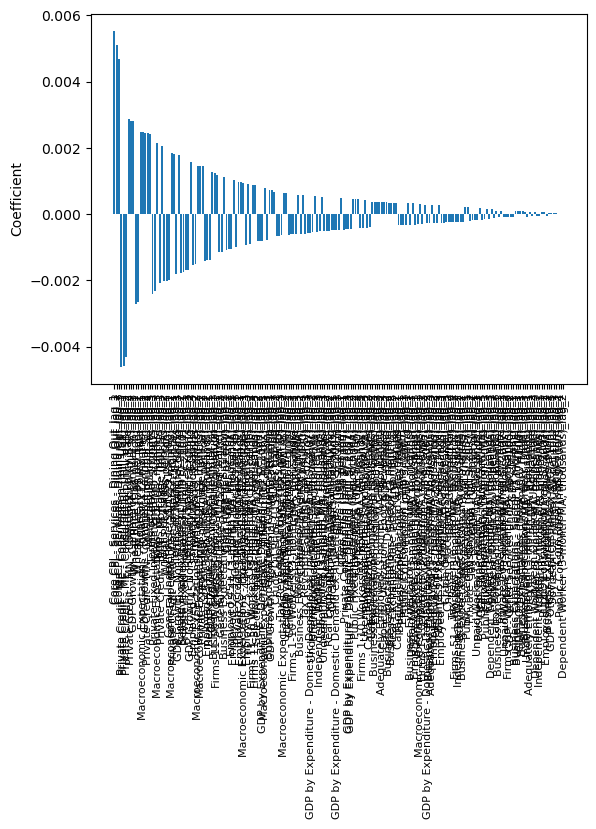

In [72]:
graph_coefficients(vars_df_ridge, value = "Coefficient", path="../../../output/3_Regression/analysis_07/h19/coef_ridge.png")

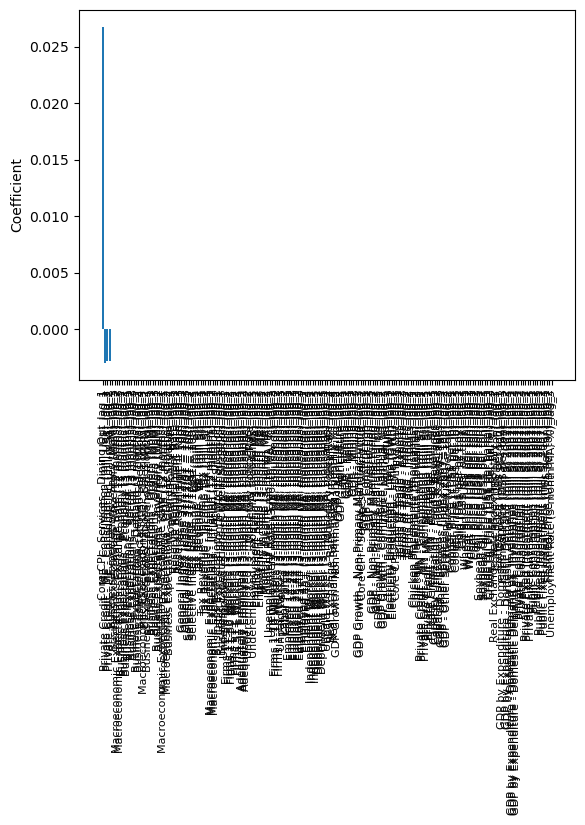

In [73]:
graph_coefficients(vars_df_lasso, value = "Coefficient", path="../../../output/3_Regression/analysis_07/h19/h19_coef_lasso.png")

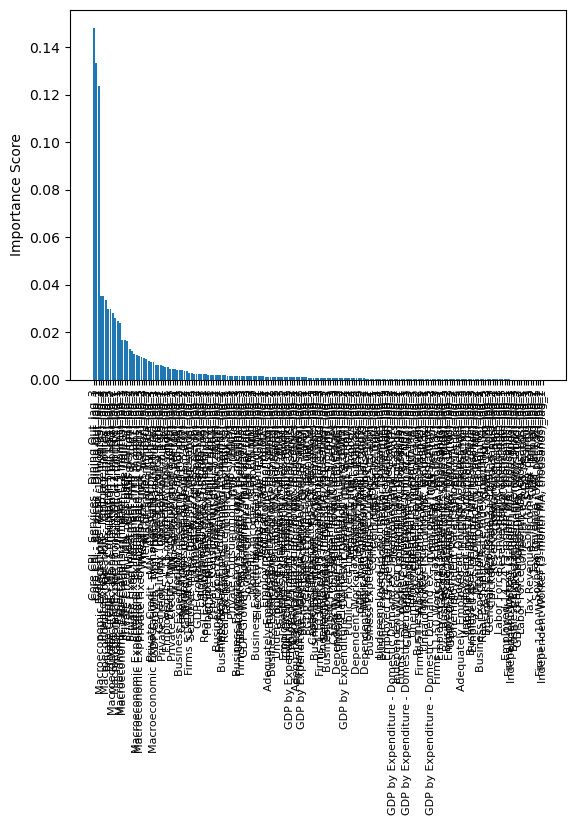

In [74]:
graph_coefficients(vars_df_rf, value = "Importance Score", path="../../../output/3_Regression/analysis_07/h19/coef_rf.png")

### 3.3.3 Prediction plots
We are going to plot our predictions in a single plot to compare visually how different models performed

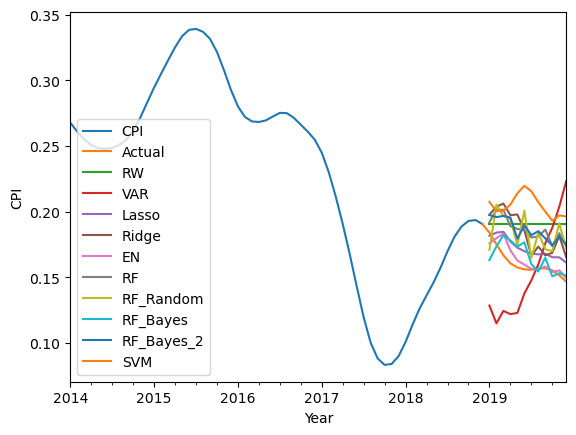

In [76]:
y_train['2014':].plot(label=None)
df['CPI']['2018-12-01':].plot(label='Actual')
results_rw['Predicted'].plot(label='RW')
results_var['Predicted'].plot(label='VAR')
results_lasso['Predicted'].plot(label='Lasso')
results_ridge['Predicted'].plot(label='Ridge')
results_en['Predicted'].plot(label='EN')
results_rf['Predicted'].plot(label='RF')
results_rf_2['Predicted'].plot(label='RF_Random')
results_rf_bayes['Predicted'].plot(label='RF_Bayes')
results_rf_bayes_2['Predicted'].plot(label='RF_Bayes_2')
results_svm['Predicted'].plot(label='SVM')

plt.legend()

#plt.title('Comparison of models predictions for 2019')
plt.xlabel('Year')
plt.ylabel('CPI')

plt.savefig('../../../output/3_Regression/analysis_07/h19/model_final_random.png', bbox_inches='tight', dpi=300)

### 3.3.4 Dielbold-Mariano test
We implement the diebold-mariano test to see if the different in forecasts is statistically significant.

In [ ]:
# # RW - VAR
# print('DM test for VAR:', dm_test(results_rw['Actual'], results_rw['Predicted'], results_var['Predicted'],  h = 3, crit="MSE"))

# # RW - Ridge
# print('DM test for Ridge: ', dm_test(results_rw['Actual'], results_rw['Predicted'], results_ridge['Predicted'],  h = 3, crit="MSE"))

# # RW - Lasso
# print('DM test for Lasso: ', dm_test(results_rw['Actual'], results_rw['Predicted'], results_lasso['Predicted'],  h = 3, crit="MSE"))

# # RW - RF
# print('DM test for RF: ', dm_test(results_rw['Actual'], results_rw['Predicted'], results_rf['Predicted'],  h = 3, crit="MSE"))

We conclude that:
- The RW appears to be better than the VAR, but it is not statiscally significant
- While the RW appers to have worse forecast predictions than the ML models, it is not statistically outperformed by the other models.

## 3.3.5 Best parameters
We here print the best parameters the Gridsearch selected for each model

In [77]:
print(lasso_params)
print(ridge_params)
print(rf_params)

{'regressor__alpha': 0.02}
{'regressor__alpha': 2.26}
{'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': 43}


In [78]:
# print(rf_params_random)
print(rf_params_bayes)
print(rf_params_bayes_2)

OrderedDict({'max_depth': 50, 'max_features': 0.14553171683249774, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 120})
OrderedDict({'max_depth': 49, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 315})
